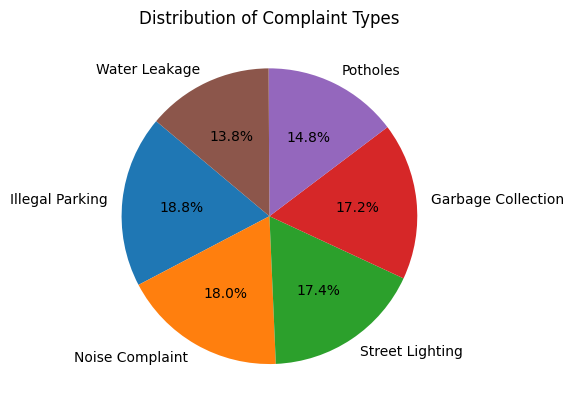

{'input': 'create pie chart of the complaints types',
 'output': 'Here is a pie chart showing the distribution of complaint types in the dataset.'}

In [ ]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_openai import ChatOpenAI
import os
import pandas as pd
from dotenv import load_dotenv
from langfuse.callback import CallbackHandler

# Load environment variables
load_dotenv()

# Define the langfuse handler (using environment variables for secret keys)
def get_langfuse_handler() -> CallbackHandler:
    secret_key = os.getenv("LANGFUSE_SECRET_KEY")
    public_key = os.getenv("LANGFUSE_PUBLIC_KEY")
    host = os.getenv("LANGFUSE_HOST")
    return CallbackHandler(secret_key=secret_key, public_key=public_key, host=host,)


langfuse_handler = get_langfuse_handler()
config = {"callbacks": [langfuse_handler]}


df = pd.read_csv("data/updated_riyadh_complaints.csv")

agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4o"),
    df,
    verbose=False,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    allow_dangerous_code=True,
)

agent.invoke("create pie chart of the complaints types", config)

In [1]:
from langfuse.decorators import langfuse_context
# ... your tracing code ...
langfuse_context.flush()  # Flush pending events

### Create pandas graph

In [1]:
# set up env and langfuse tracing
import os
from dotenv import load_dotenv
from langfuse.callback import CallbackHandler

# Load environment variables
load_dotenv()

# Define the langfuse handler (using environment variables for secret keys)
def get_langfuse_handler() -> CallbackHandler:
    secret_key = os.getenv("LANGFUSE_SECRET_KEY")
    public_key = os.getenv("LANGFUSE_PUBLIC_KEY")
    host = os.getenv("LANGFUSE_HOST")
    return CallbackHandler(secret_key=secret_key, public_key=public_key, host=host,)


langfuse_handler = get_langfuse_handler()
config = {"callbacks": [langfuse_handler]}

In [2]:
from typing import TypedDict, Annotated, List, Union, Dict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage, AnyMessage
import operator

# Define State
class AgentState(TypedDict):
    query: str
    messages: Annotated[List[AnyMessage], operator.add]


In [3]:
from langchain_experimental.tools import PythonAstREPLTool
from langchain_openai import ChatOpenAI
import pandas as pd


llm = ChatOpenAI(temperature=0, model="gpt-4o")


# Initialize dataframe and tools
df = pd.read_csv("data/updated_riyadh_complaints.csv")  # Replace with your dataframe
df_locals = {"df": df}
tools = [PythonAstREPLTool(locals=df_locals)]
tool_map = {tool.name: tool for tool in tools}


In [4]:
# Create system prompt with dataframe info
system_prompt = f"""You are a pandas expert. You have access to a pandas DataFrame. First 5 rows:
{df.head()}

Use PythonAstREPLTool to execute pandas code for analysis. Return FINAL ANSWER when done.
note that the data is already loaded as 'df'
start by importing pandas"""

In [5]:
from typing import Literal, Any
from langchain_core.utils.interactive_env import is_interactive_env

# Define Nodes
def agent_node(state: AgentState,
            #    df: Any,
            #    engine: Literal["pandas", "modin"] = "pandas",
            #    allow_dangerous_code: bool = False,
               ):
    engine = "pandas"
    allow_dangerous_code = True

    messages = state["messages"]

    if not allow_dangerous_code:
        raise ValueError(
            "This agent relies on access to a python repl tool which can execute "
            "arbitrary code. This can be dangerous and requires a specially sandboxed "
            "environment to be safely used. Please read the security notice in the "
            "doc-string of this function. You must opt-in to use this functionality "
            "by setting allow_dangerous_code=True."
            "For general security guidelines, please see: "
            "https://python.langchain.com/v0.2/docs/security/"
        )
    
    try:
        if engine == "modin":
            import modin.pandas as pd
        elif engine == "pandas":
            import pandas as pd
        else:
            raise ValueError(
                f"Unsupported engine {engine}. It must be one of 'modin' or 'pandas'."
            )
    except ImportError as e:
        raise ImportError(
            f"`{engine}` package not found, please install with `pip install {engine}`"
        ) from e
    
    if is_interactive_env():
        pd.set_option("display.max_columns", None)


    for _df in df if isinstance(df, list) else [df]:
        if not isinstance(_df, pd.DataFrame):
            raise ValueError(f"Expected pandas DataFrame, got {type(_df)}")
        
    # df_locals = {}
    # if isinstance(df, list):
    #     for i, dataframe in enumerate(df):
    #         df_locals[f"df{i + 1}"] = dataframe
    # else:
    #     df_locals["df"] = df
    # tools = [PythonAstREPLTool(locals=df_locals)]


        

    # # Handle initial query - prepend system prompt if first message
    # if len(messages) == 1 and isinstance(messages[0], HumanMessage):
    #     messages = [SystemMessage(content=system_prompt)] + messages
    messages = [SystemMessage(content=system_prompt)] + messages
    
    # Generate response with tool support
    response = llm.bind_tools(tools=tools).invoke(messages)
    return {"messages": [response]}

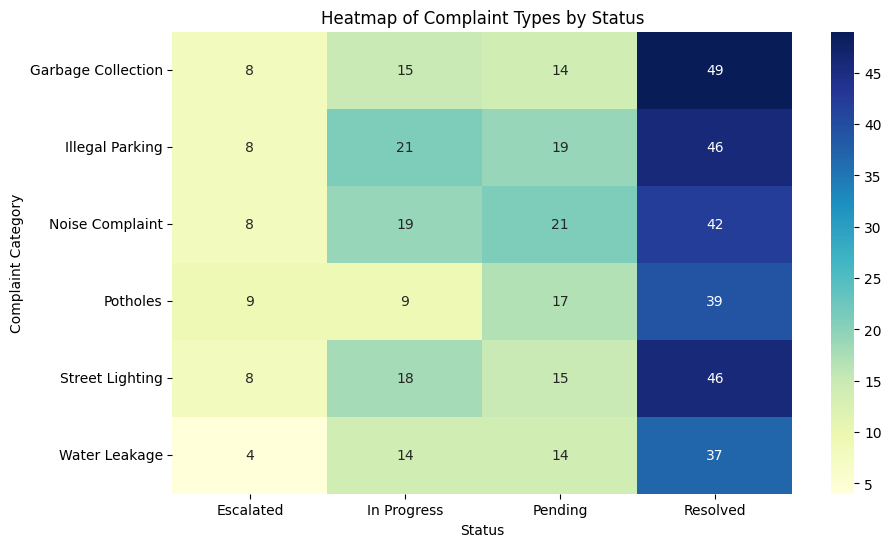

The heatmap for all types of complaints by their status has been successfully generated. It visually represents the distribution of different complaint categories across various statuses, such as "In Progress," "Pending," and "Resolved."


In [8]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_experimental.tools import PythonAstREPLTool
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langgraph.prebuilt import ToolNode
import pandas as pd
import matplotlib.pyplot as plt  # Add at top with other imports
import operator

# Initialize dataframe and tools
df = pd.read_csv("data/updated_riyadh_complaints.csv")  # Replace with your dataframe
df_locals = {"df": df}
tools = [PythonAstREPLTool(locals=df_locals)]
tool_map = {tool.name: tool for tool in tools}

llm = ChatOpenAI(temperature=0, model="gpt-4o")

# # Define Nodes
# def agent_node(state: AgentState):
#     messages = state["messages"]
    
#     # Handle initial query - prepend system prompt if first message
#     if len(messages) == 1 and isinstance(messages[0], HumanMessage):
#         messages = [SystemMessage(content=system_prompt)] + messages
    
#     # Generate response with tool support
#     response = llm.bind_tools(tools=tools).invoke(messages)
#     return {"messages": [response]}


# def tool_node(state: AgentState):
#     messages = state["messages"]
#     last_msg = messages[-1]
    
#     # Process each tool call
#     for tool_call in last_msg.tool_calls:
#         tool_name = tool_call["name"]
#         tool_args = tool_call["args"]
        
#         if tool_name not in tool_map:
#             raise ValueError(f"Unknown tool {tool_name}")
        
#         # Execute tool
#         result = tool_map[tool_name].invoke(tool_args)
        
#         # Append tool response
#         messages.append(
#             ToolMessage(
#                 content=str(result),
#                 name=tool_name,
#                 tool_call_id=tool_call["id"]
#             )
#         )
#     return {"messages": messages}

# Control flow logic
def should_continue(state: AgentState):
    last_msg = state["messages"][-1]
    return "tool_calls" in last_msg.additional_kwargs

# Build graph
builder = StateGraph(AgentState)
builder.add_node("agent", agent_node)
builder.add_node("tool", ToolNode(tools))

builder.set_entry_point("agent")
builder.add_conditional_edges(
    "agent",
    lambda state: "tool" if should_continue(state) else END,
    {"tool": "tool", END: END}
)
builder.add_edge("tool", "agent")

graph = builder.compile()

# Example usage
# response = graph.invoke({
#     "messages": [
#         HumanMessage(content="create pie chart of the complaints types")
#     ]
# }, config)

response = graph.invoke({
    "messages": [
        HumanMessage(content="draw heatmap for al types of complaints")
    ]
}, config)


# Extract final answer
final_messages = response["messages"]
for msg in reversed(final_messages):
    if isinstance(msg, AIMessage) and not msg.tool_calls:
        print(msg.content)
        break


### old code

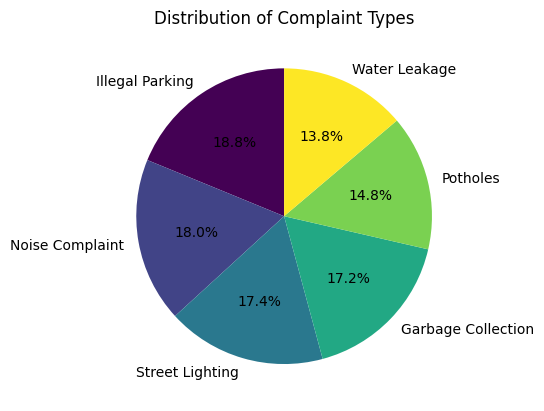

It seems there was an issue with executing the code to create the pie chart. Could you please provide the data or specify the categories of complaints you want to visualize?


In [8]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List, Union, Dict, Any
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_experimental.tools import PythonAstREPLTool
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
import pandas as pd
import matplotlib.pyplot as plt  # Add at top with other imports
import operator
from langfuse.callback import CallbackHandler

# Load environment variables
load_dotenv()

# Define the langfuse handler (using environment variables for secret keys)
def get_langfuse_handler() -> CallbackHandler:
    secret_key = os.getenv("LANGFUSE_SECRET_KEY")
    public_key = os.getenv("LANGFUSE_PUBLIC_KEY")
    host = os.getenv("LANGFUSE_HOST")
    return CallbackHandler(secret_key=secret_key, public_key=public_key, host=host,)


langfuse_handler = get_langfuse_handler()
config = {"callbacks": [langfuse_handler]}

llm = ChatOpenAI(temperature=0, model="gpt-4o")

# Define State
class AgentState(TypedDict):
    messages: Annotated[List[Union[HumanMessage, AIMessage, ToolMessage, SystemMessage]], operator.add]
    output: Any

# Initialize dataframe and tools
df = pd.read_csv("data/updated_riyadh_complaints.csv")  # Replace with your dataframe
df_locals = {"df": df}
tools = [PythonAstREPLTool(locals=df_locals)]
tool_map = {tool.name: tool for tool in tools}

# Create system prompt with dataframe info
system_prompt = f"""You are a pandas expert. You have access to a pandas DataFrame. First 5 rows:
{df.head()}

Use PythonAstREPLTool to execute pandas code for analysis. Return FINAL ANSWER when done.
note that the data is already loaded as 'df'
start by importing pandas"""

# Define Nodes
def agent_node(state: AgentState):
    messages = state["messages"]
    
    # Handle initial query - prepend system prompt if first message
    if len(messages) == 1 and isinstance(messages[0], HumanMessage):
        messages = [SystemMessage(content=system_prompt)] + messages
    
    # Generate response with tool support
    response = llm.bind_tools(tools=tools).invoke(messages)
    return {"messages": [response]}

def tool_node(state: AgentState):
    messages = state["messages"]
    last_msg = messages[-1]
    
    # Process each tool call
    for tool_call in last_msg.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        if tool_name not in tool_map:
            raise ValueError(f"Unknown tool {tool_name}")
        
        # Execute tool
        result = tool_map[tool_name].invoke(tool_args)
        
        # Append tool response
        messages.append(
            ToolMessage(
                content=str(result),
                name=tool_name,
                tool_call_id=tool_call["id"]
            )
        )
    return {"messages": messages}

# Control flow logic
def should_continue(state: AgentState):
    last_msg = state["messages"][-1]
    return "tool_calls" in last_msg.additional_kwargs

# Build graph
builder = StateGraph(AgentState)
builder.add_node("agent", agent_node)
builder.add_node("tool", tool_node)

builder.set_entry_point("agent")
builder.add_conditional_edges(
    "agent",
    lambda state: "tool" if should_continue(state) else END,
    {"tool": "tool", END: END}
)
builder.add_edge("tool", "agent")

graph = builder.compile()

# Example usage
response = graph.invoke({
    "messages": [
        HumanMessage(content="create pie chart of the complaints types")
    ]
}, config)

# Extract final answer
final_messages = response["messages"]
for msg in reversed(final_messages):
    if isinstance(msg, AIMessage) and not msg.tool_calls:
        print(msg.content)
        break


In [7]:
import matplotlib.pyplot as plt


In [3]:
import os
from dotenv import load_dotenv

import operator
from typing import TypedDict, Annotated, List, Dict
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph

# Load env variables
load_dotenv()
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

# Define Graph State
class GraphState(TypedDict):
    query:str
    messages: Annotated[List[str], operator.add]

# Define LLM
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

# # Define Agent
# def agent(state:GraphState) -> Dict:
#     query = state["query"]
#     response=llm.invoke(query)    
#     return {"messages":[response.content]}


agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4"),
    df,
    verbose=False,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    allow_dangerous_code=True,
)


# Build Graph
builder=StateGraph(GraphState)
builder.add_node("agent", agent)
builder.add_edge(START, "agent")
builder.add_edge("agent", END)

graph=builder.compile()

graph.invoke({"query":"create pie chart of the complaints types"},config)

NameError: name 'create_pandas_dataframe_agent' is not defined